## Plotting ISCO sample inventory over winter 2023 discharge

### Discharge data from Satish in sonya-may2024 directory

## TO DO:

- [ ] the datetime combination in Section 3 is very ugly but functional, make that more efficient
- [ ] add in met data

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: viridisLite


Attaching package: ‘data.table’


The following objects are masked from ‘package:lubridate’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose


Rows: 138 Columns: 30
── Column specification ────────────────────────────────────────────────────────


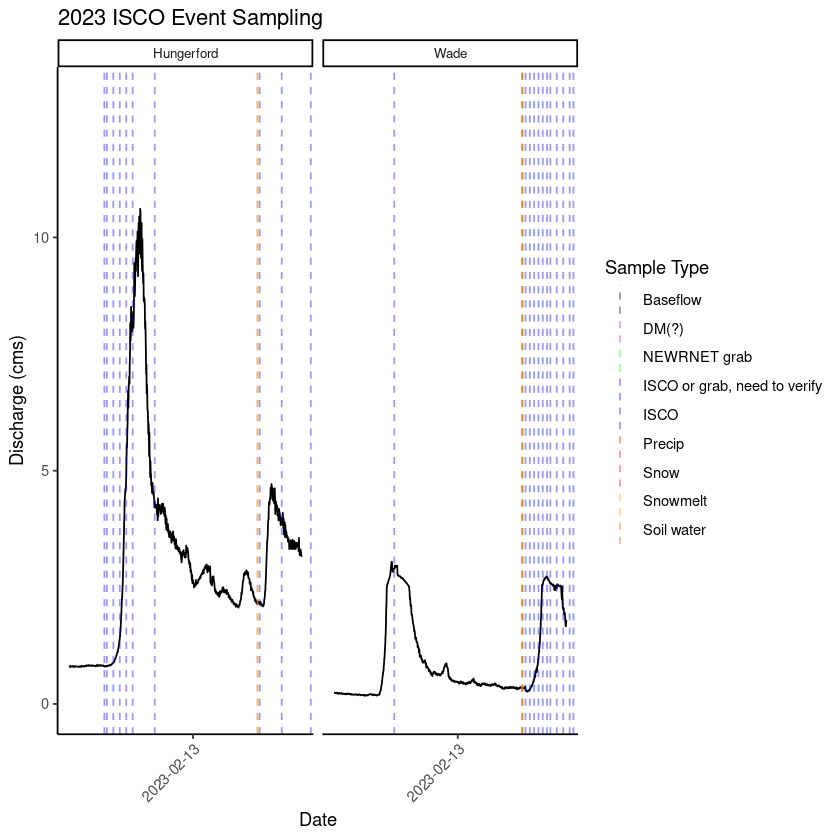

In [1]:
#################
# LOAD PACKAGES #
#################

library(tidyverse)
library(viridis)
library(dplyr)
library(lubridate)
library(caTools)  # for numerical integration
library(data.table) # for nearest join of q and ISCO data

###################
# SET DIRECTORIES #
###################

q_input_dir <- "~//OneDrive/git-repos/cQ_analysis/millar2021_R_separation_hysteresis/sonya-may24/data"
c_input_dir <- "~//OneDrive/git-repos/EMMA/data"
m_input_dir <- "~//OneDrive/git-repos/cQ_analysis/baseflow-rules-determinaton/data/"
output_dir <- "~//OneDrive/git-repos/EMMA/output/"

##########################
# READ IN AND CLEAN DATA #
##########################

# read in the RI23 data
# see joining here: 
# https://github.com/MeganEDuffy/EMMA/blob/main/isco_metadata/LCBP_RI_sample_index/RI23-sample-ID-join.ipynb
MetadataISCO <- read_csv(file.path(c_input_dir, "/newrnet-chemistry/RI23-IC-ICP-isotope-joined.csv"))

# Convert the "Date" column to date format and Time to time format
MetadataISCO$Date <- mdy(MetadataISCO$Date)  # mdy() parses dates in "month/day/year" format 

# Combine Date, Time, and Time zone columns into a single Datetime column
MetadataISCO <- MetadataISCO %>%
  mutate(Datetime = ymd_hms(paste(Date, format(Time, "%H:%M:%S"), "Time Zone")))

# Read in the q data
Hungerford_q <- read_csv(file.path(q_input_dir, "hb_q_chem.csv")) %>%
  mutate(q_cms = q_cms_hb)
Wade_q <- read_csv(file.path(q_input_dir, "wb_q_chem.csv")) %>%
  mutate(q_cms = q_cms_wb)

# Read in the met data for air temp
Hungerford_m <- read_csv(file.path(m_input_dir, "hungerford_2020-2024_met_2024-11-08.csv")) %>%
  filter(Timestamp > as.Date("2023-01-01 00:00:00"), 
        Timestamp < as.Date("2023-04-20 00:00:00")) %>%
  mutate(Stream = "Hungerford")
  
Wade_m <- read_csv(file.path(m_input_dir, "wade_2020-2024_met_2024-11-08.csv")) %>%
  filter(Timestamp > as.Date("2023-01-01 00:00:00"), 
        Timestamp < as.Date("2023-04-20 00:00:00")) %>%
  mutate(Stream = "Wade")

#######################
# PLOT THE HYDROGRAPH #
#######################

# Filter out rows with NA in the Site column and then add the Stream column
MetadataISCO <- MetadataISCO %>%
  filter(!is.na(Site)) %>%                # Remove rows with NA in Site
  mutate(Stream = ifelse(Site == "Hungerford", "Hungerford", "Wade"))

# Combine discharge data with a "Stream" column
combined_data <- bind_rows(
  Hungerford_q %>% mutate(Stream = "Hungerford"),
  Wade_q %>% mutate(Stream = "Wade")
)

# Plot with facet_wrap for side-by-side subplots
hydrograph_plot_ISCO_with_lines <- ggplot() +
  # Plot stream discharge data for each stream
  geom_line(data = combined_data, aes(x = datetime, y = q_cms)) +

  # Add air temperature from met data
  #geom_line(data = Hungerford_m, aes(x = Timestamp, y = Air_Temp)) +
  
  # Add vertical lines for each sample type within the correct stream's facet
  geom_vline(data = MetadataISCO, aes(xintercept = Datetime, color = Type), linetype = "dashed", alpha = 0.4) +
  
  theme_classic() +
  scale_x_datetime(
    limits = c(as.POSIXct('2023-02-08 00:00:00'), as.POSIXct('2023-02-17 00:00:00')),
    date_labels = "%Y-%m-%d",
    date_breaks = "1 week"
  ) +
  # Set consistent y-axis range for both subplots
  scale_y_continuous(limits = c(0, 13)) +
  labs(title = "2023 ISCO Event Sampling",
       x = "Date",
       y = "Discharge (cms)",
       color = "Sample Type") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1),
        strip.text = element_text(size = 8)) +
  
  # Use facet_wrap to separate data by Stream
  facet_wrap(~ Stream, ncol = 2) +
  
  # Define colors for each sample type in the legend
  scale_color_manual(
    values = c("Isco" = "blue", "Grab/Isco" = "blue", "Baseflow" = "black", "Snow" = "red", "Precip" = "red",
               "Snowmelt lysimeter" = "orange", "Soil water lysimeter" = "darkorange3", "DM" = "purple", 
               "Grab" = "green"),
    labels = c("Isco" = "ISCO", 
               "Snow" = "Snow", "Precip" = "Precip", "Baseflow" = "Baseflow", "Snowmelt lysimeter" = "Snowmelt", 
               "Soil water lysimeter" = "Soil water", "DM" = "DM(?)", "Grab" = "NEWRNET grab", "Grab/Isco" = "ISCO or grab, need to verify")
  )

# Save the plot with specified dimensions
ggsave(file.path(output_dir, "RI23_hydrograph_plot_ISCO_with_lines.png"), plot = hydrograph_plot_ISCO_with_lines, width = 14, height = 6, dpi = 500)

# Display the plot
print(hydrograph_plot_ISCO_with_lines)

Warning message:
“Removed 19 rows containing missing values (`geom_line()`).”
Warning message:
“Removed 452 rows containing missing values (`geom_line()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_vline()`).”
Warning message:
“Removed 19 rows containing missing values (`geom_line()`).”
Warning message:
“Removed 452 rows containing missing values (`geom_line()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_vline()`).”


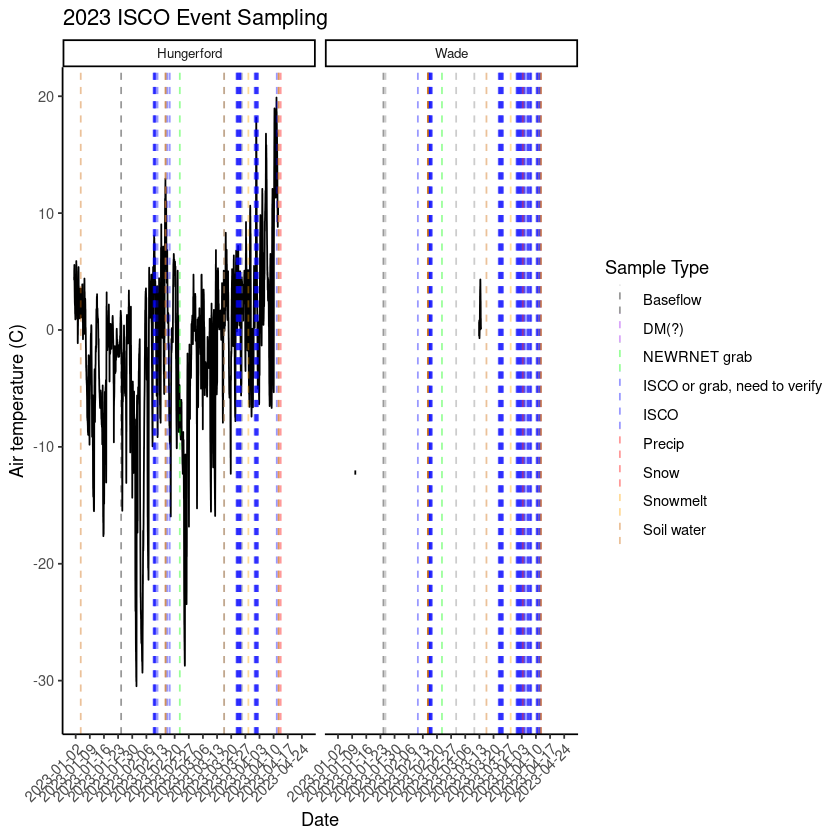

In [126]:
# Plot with facet_wrap for side-by-side subplots of air temp
temp_plot_ISCO <- ggplot() +
  # Add air temperature from met data
  geom_line(data = Hungerford_m, aes(x = Timestamp, y = Air_Temp)) +
  geom_line(data = Wade_m, aes(x = Timestamp, y = Air_Temp)) +
  
  # Add vertical lines for each sample type within the correct stream's facet
  geom_vline(data = MetadataISCO, aes(xintercept = Datetime, color = Type), linetype = "dashed", alpha = 0.4) +
  
  theme_classic() +
  scale_x_datetime(
    limits = c(as.POSIXct('2023-01-01 00:00:00'), as.POSIXct('2023-04-25 00:00:00')),
    date_labels = "%Y-%m-%d",
    date_breaks = "1 week"
  ) +
  # Set consistent y-axis range for both subplots
  #scale_y_continuous(limits = c(0, 13)) +
  labs(title = "2023 ISCO Event Sampling",
       x = "Date",
       y = "Air temperature (C)",
       color = "Sample Type") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1),
        strip.text = element_text(size = 8)) +
  
  # Use facet_wrap to separate data by Stream
  facet_wrap(~ Stream, ncol = 2) +
  
  # Define colors for each sample type in the legend
  scale_color_manual(
    values = c("Isco" = "blue", "Grab/Isco" = "blue", "Baseflow" = "black", "Snow" = "red", "Precip" = "red",
               "Snowmelt lysimeter" = "orange", "Soil water lysimeter" = "darkorange3", "DM" = "purple", 
               "Grab" = "green"),
    labels = c("Isco" = "ISCO", 
               "Snow" = "Snow", "Precip" = "Precip", "Baseflow" = "Baseflow", "Snowmelt lysimeter" = "Snowmelt", 
               "Soil water lysimeter" = "Soil water", "DM" = "DM(?)", "Grab" = "NEWRNET grab", "Grab/Isco" = "ISCO or grab, need to verify")
  )

# Save the plot with specified dimensions
ggsave(file.path(output_dir, "RI23_temp_plot_ISCO.png"), plot = temp_plot_ISCO, width = 14, height = 6, dpi = 500)

# Display the plot
print(temp_plot_ISCO)